# Decision Boundary Example
The class ``DecisionBoundary`` can be used to plot any decision boundary (linear and non-linear) against 2D axes.
If the data has more than two dimensions, it is down-sampled first using PCA (or any other passed down-sampler).

Chapter two discusses problems with down-sampling higher dimensional data.

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append("../")

from aif360.datasets import GermanDataset
from aif360.datasets import BinaryLabelDataset

from fairensics.data.synthetic_dataset import SyntheticDataset
from fairensics.data.decision_boundary import DecisionBoundary 
from fairensics.methods import FairDisparateImpact, AccurateDisparateImpact
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# 0. Load and Plot Data
The synthetic data set contains two unprotected features and the protected attribute as described in the previous jupyter notebook.

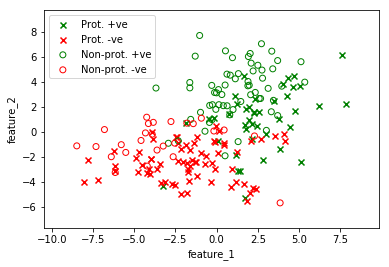

In [2]:
syn = SyntheticDataset()
syn_train, syn_test = syn.split([0.7], shuffle=True)
syn_train.plot()

Red points are individuals with negative label (i.e. do not qualify for a job) and green individuals with positive label (qualify for the job). A perfect classifier would separate the points perfectly.

## 0.1 Training Classifiers on Synthetic Data set
Two classifiers are trained, one with fairness constraint and logistic regression from ``sklearn`` as baseline.

In [3]:
# fit disparate impact remover
dspim_f = FairDisparateImpact()
dspim_f.fit(syn)

# and logistic regression from sklearn
skclf = LogisticRegression()
skclf.fit(syn_train.features[:, :2], syn_train.labels.ravel())
print()

../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between label and attribute  for protected attribute: protected_attribute is  above threshold of 0.4
  warnings.warn(warning_msg)


# 1. Plotting Decision Boundaries
The decision boundaries are plotted using a mesh grid, therefore both linear and non-linear boundaries can be plotted.
Two methods are used for plotting, ``scatter`` to scatter plot the points and ``add_boundary`` to add a decision boundary. Multiple boundaries can be added to the same plot. 

The scatter and add_boundary functions both take AIF360 BinaryLabelDatasets as input.

**``add_boundary()`` only uses the data set to estimate the min-max values for each dimension.**

## 1.1. Plotting Decision Boundary on 2D Data

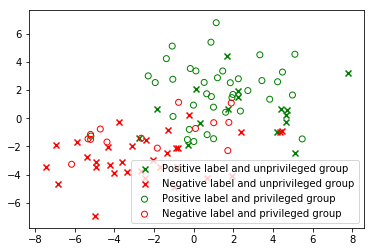

In [4]:
# first, only the points are scattered
dec_bound = DecisionBoundary()
dec_bound.scatter(syn)
dec_bound.show()

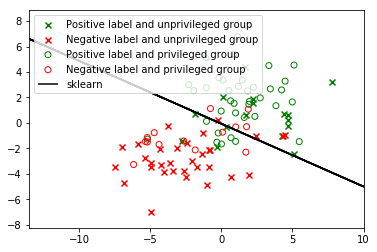

In [5]:
# add the sklearn decision boundary
dec_bound.scatter(syn)
dec_bound.add_boundary(syn, skclf, label="sklearn", num_points=1000)
dec_bound.show()                  

## 1.2 Interpreting the Decision Boundary
The decision boundary can be used to estimate the effects of different decision functions. In a fairness context, it might for instance help to estimate how a certain restriction impacts the decision function.

### 1.2.1 Small Impact of Fairness Constraint
In the following example, the fairness constraint only has a minor impact on the decision function. The decision boundaries are almost the same.

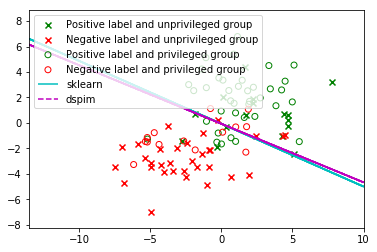

In [6]:
dec_bound.scatter(syn)
dec_bound.add_boundary(syn, skclf, label="sklearn", num_points=1000)
dec_bound.add_boundary(syn, dspim_f, label="dspim", num_points=1000)
dec_bound.show()  

### 1.2.2 Larger Impact of Constraint
In this example, the constraint has a larger impact on the decision boundary (i.e. a totally different classifier is learned):

In [7]:
# fit disparate impact remover
dspim_acc = AccurateDisparateImpact()
dspim_acc.fit(syn)

../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between label and attribute  for protected attribute: protected_attribute is  above threshold of 0.4
  warnings.warn(warning_msg)


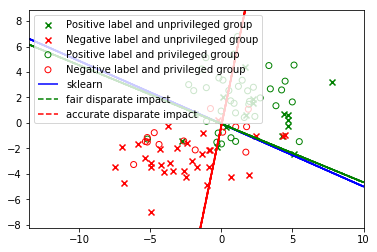

In [8]:
dec_bound.scatter(syn)
dec_bound.add_boundary(syn, skclf, label="sklearn", num_points=1000)
dec_bound.add_boundary(syn, dspim_f, label="fair disparate impact", num_points=1000)
dec_bound.add_boundary(syn, dspim_acc, label="accurate disparate impact", num_points=1000)
dec_bound.show()  

## 1.3 Coloring the Background
By passing a value to ``cmap`` the background is colored according to the color map. The value is a string as described in https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html.

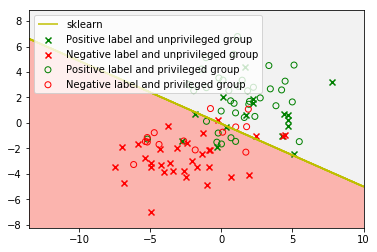

In [9]:
dec_bound.add_boundary(syn, skclf, label="sklearn", num_points=1000, cmap="Pastel1")
dec_bound.scatter(syn)
dec_bound.show()

# 2. Higher Dimensional Data

Decision boundaries for data with more than two dimensions can also be plotted by down-sampling the data to two dimensions.
This doesn't always produce meaningful results as described below.

## 2.1 Intuition
Down-sampling creates meaningful decision boundaries if the down-sampled components contain relevant dimensions for the decision boundary. In PCA (the default down-sampler used by the DecisionBoundary class) this is the case, if the decision boundary cuts through the axes with most variance.

In [10]:
# define data seperated along axes with most variance
x = np.asarray(range(-50, 50), dtype=np.float32)
y = np.random.normal(0, .15, 100)
z = x**2 + 1
labels = [1 if  i < 500 else 0 for i in z]

In [11]:
# define hyper plane
xx, yy = np.meshgrid(range(-50, 50), range(-1, 2))
zz = np.ones(xx.shape) * 500

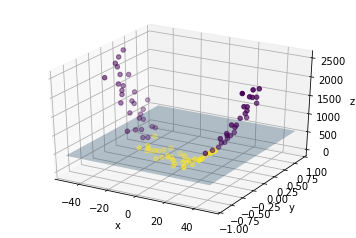

In [12]:
# plot the data
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=labels)
ax.plot_surface(xx, yy, zz, alpha=.3)

ax.set_ylim([-1,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

The axes with the most variance is $z$ and the separating hyperplane cuts through this axis. Therefore, the decision boundary will be meaningful on the down scaled data.

In [13]:
# Applying PCA
pca = PCA(n_components=2)
data = np.column_stack((x, y, z))
downsampled_data = pca.fit_transform(data)

print(data.shape)
print(downsampled_data.shape)

(100, 3)
(100, 2)


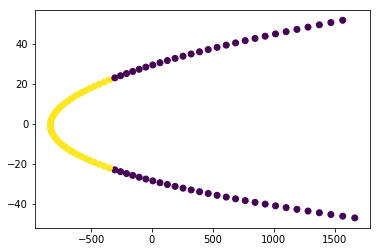

In [14]:
# plotting the principal components encoding most of the variance
plt.scatter(downsampled_data[:, 0], downsampled_data[:, 1], c=labels)
plt.show()

The parabola is transposed, because the first principal component encodes more variance.

## 2.1.1 Plotting the Decision Boundary

In [15]:
# transform data into aif data frame for decsion boundary plotting
p = np.random.randint(2, size=len(x))
data_pd = pd.DataFrame({"y": y, "x": x, "z": z, "p": p, "label": labels})

data_aif = BinaryLabelDataset(favorable_label=1,
                              unfavorable_label=0,
                              df=data_pd,
                              label_names=["label"],
                              protected_attribute_names=["p"],
                              privileged_protected_attributes=0,
                              unprivileged_protected_attributes=1)


In [16]:
# train a classifier
clf = LogisticRegression()
clf.fit(data, labels)
clf.score(data, labels)

0.98

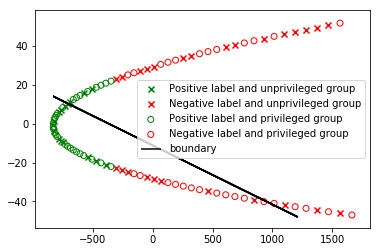

In [17]:
# ploting teh decision boundary
dec_bound = DecisionBoundary()
dec_bound.scatter(data_aif)
dec_bound.add_boundary(data_aif, clf, label="boundary", num_points=1000)
dec_bound.show()

The decision boundary is a line cutting the first principal component somewhere at $\approx$ -550. The separating hyperplane in the 3D data cuts at $z$ $\approx$ 500.

### 2.2.2 When Down-sampling fails
The above method only works if the directions of the principal components also encode relevant dimensions for classification. This is not the case in the following example:

In [18]:
# define data
x1 = np.asarray(range(-50, 50), dtype=np.float32) + np.random.normal(0, .5, 100)
y1 = np.random.normal(-.2, .1, 100)
z1 = x1**2 + 1

x2 = np.asarray(range(-50, 50), dtype=np.float32) + np.random.normal(0, .5, 100)
y2 = np.random.normal(.2, .1, 100)
z2 = x2**2 + 1

x = np.hstack((x1, x2))
y = np.hstack((y1, y2))
z = np.hstack((z1, z2))

labels = np.hstack((np.ones(100), np.zeros(100)))

In [19]:
# define hyper plane
xx, zz = np.meshgrid(range(-50, 50), range(0, 2500))
yy = np.ones(zz.shape) *.1

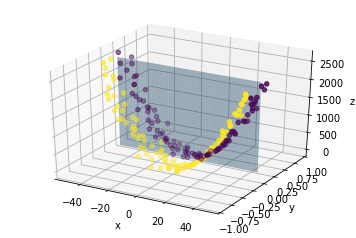

In [20]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c = labels)
ax.plot_surface(xx, yy, zz,  alpha=.4)

ax.set_ylim([-1,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In the figure above, the hyperplane separates the two-point clouds well, but on the $y$ axes which has the lowest variance. PCA, however, will project the points mainly on the $x$ and $z$ axes since they have a larger variance.

In [21]:
# Applying PCA
pca = PCA(n_components=2)
data = np.column_stack((x, y, z))
downsampled_data = pca.fit_transform(data)

print(data.shape)
print(downsampled_data.shape)

(200, 3)
(200, 2)


In [22]:
# transform data into aif data frame for decsion boundary plotting
p = np.random.randint(2, size=len(x))
data_pd = pd.DataFrame({"y": y, "x": x, "z": z, "p": p, "label": labels})

data_aif = BinaryLabelDataset(favorable_label=1,
                              unfavorable_label=0,
                              df=data_pd,
                              label_names=["label"],
                              protected_attribute_names=["p"],
                              privileged_protected_attributes=0,
                              unprivileged_protected_attributes=1)


In [23]:
clf = LogisticRegression()
clf.fit(data, labels)
clf.score(data, labels)

0.99

The accuracy is still 99\%, hence,  the classifier learns to separate the two classes well. However, looking on the decision boundary on the two main components of PCA, the boundary seems arbitrary.

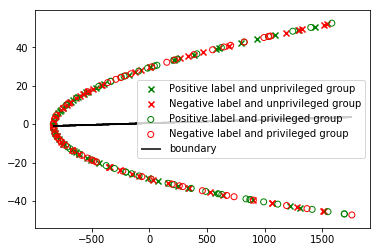

In [24]:
dec_bound = DecisionBoundary()
dec_bound.scatter(data_aif, num_to_draw=200)
dec_bound.add_boundary(data_aif, clf, label="boundary", num_points=1000)
dec_bound.show()

This plot does not really help, because the decision boundary seems arbitrary.

## 2.3 Down-Sampler

The default down-sampler is PCA. Other functions can be passed as parameter if they provide two functions:
``fit_transform`` for down-sampling and ``inverse_transform`` for up-sampling.


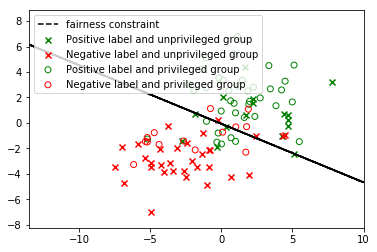

In [25]:
from sklearn.decomposition import NMF

dec_bound = DecisionBoundary(downsampler=NMF(n_components=2))
dec_bound.add_boundary(syn, dspim_f, label="fairness constraint", num_points=1000)
dec_bound.scatter(syn)
dec_bound.show()

# 3. Real World Data Example
Most real data set have more than two dimensions and must be down-sampled first.

In [26]:
# load the german credit data set
gcd = GermanDataset()
gcd_train, gcd_test = gcd.split([0.7], shuffle=True)

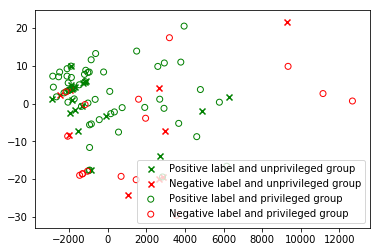

In [27]:
# scatter plot the first two principal components of the gcd
dec_bound = DecisionBoundary()
dec_bound.scatter(gcd)
dec_bound.show()

In [28]:
# train fair classifier on german credit data set
dspim_f = FairDisparateImpact()
dspim_f.fit(gcd_train)

../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between groups  for protected attribute: age is  above threshold of 0.4
  warnings.warn(warning_msg)
../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between label and attribute  for protected attribute: sex is  above threshold of 0.4
  warnings.warn(warning_msg)
../fairensics/methods/fairness_warnings.py:203: UserWarning: Ratio  between label and attribute  for protected attribute: age is  above threshold of 0.4
  warnings.warn(warning_msg)
../fairensics/methods/disparate_impact.py:364: UserWarning: Only the first protected attribute is considered with this constraint.
  warnings.warn("Only the first protected attribute is considered with this constraint.")


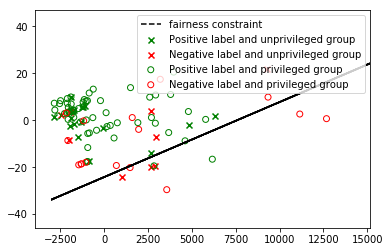

In [29]:
# plot the decision boundary against the first two principal components
dec_bound = DecisionBoundary()
dec_bound.add_boundary(gcd, dspim_f, label="fairness constraint", num_points=1000)
dec_bound.scatter(gcd)
dec_bound.show()

Again, red points are individuals with a negative label and green with positive label. An optimal decision function would perfectly separate green and red points.